In [1]:
from bs4 import BeautifulSoup
from datetime import datetime
import requests
from IPython.display import clear_output
import time
import webbrowser
import numpy as np
import unicodedata
import pickle
import pandas as pd
import codecs
import matplotlib.pyplot as plt

In [2]:
StartYear = 2008
StartMon = 12
EndYear = 2020
EndMon = 12

#ListofTime = [] #200812 - 201903
LinkHeader = "https://www.checkee.info/main.php?dispdate="

#Function to create time list
def ListofTime_generator(StartYear,StartMon,EndYear,EndMon):
    ListofTime = []
    while(StartYear!=EndYear or StartMon!=EndMon):
        ListofTime.append(str(StartYear) + "-" + str(StartMon).zfill(2))
        if StartMon == 12:
            StartYear += 1
            StartMon = 1
        else:
            StartMon += 1
    return ListofTime

ListofTime = ListofTime_generator(StartYear,StartMon,EndYear,EndMon)

#print(ListofTime)
AllPages = {}
len_month = len(ListofTime)
start_time = time.time()
count = 1
for months in ListofTime:
    clear_output()
    cur_time = time.time()
    print("requesting from " + LinkHeader + months)
    print("Progress: ",count,"/",len_month)
    print("time elapsed:",int(cur_time-start_time),"seconds")
    estimation = int((cur_time-start_time)/count*(len_month-count))
    print("Estimate Time Left:", estimation/60, "minuites")
    session = requests.Session()
    page = session.get(LinkHeader + months, headers={'User-Agent': 'Mozilla/5.0'})
    AllPages[months] = page.content.decode("utf-8","ignore")
    count += 1

#page = session.get(ListofTime[0], headers={'User-Agent': 'Mozilla/5.0'})
#headers ={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'} 
#page = requests.get(ListofTime[0],headers)

#save the extrcted data to npy file
#now = datetime.now()
#date_time = now.strftime("%m-%d-%Y_%H-%M")
#filename = date_time +".npy"
#np.save(filename, AllPages)

requesting from https://www.checkee.info/main.php?dispdate=2020-11
Progress:  144 / 144
time elapsed: 238 seconds
Estimate Time Left: 0.0 minuites


In [32]:
#use strtmp for develope
class ApplicationCase():
    def __init__(self, ID):
        self.ID = ID
        self.VisaType = None
        self.VisaEntry = None
        self.Consulate = None
        self.Major = None
        self.CheckDate = None
        self.CompleteDate = None
        self.WaitingDays = None
        self.Comment = None
        self.Status = None

    def DebugPrint(self):
        if self.CompleteDate:
            print("----   This case is completed   ----")
        else:
            print("**** This case is not completed ****")
        print("ID            :",self.ID)
        print("Visa Type     :",self.VisaType)
        print("Visa Entry    :",self.VisaEntry)
        print("Consulate     :",self.Consulate)
        print("Major         :",self.Major)
        print("Status        :",self.Status)
        print("Check Date    :",self.CheckDate)
        print("Complete Date :",self.CompleteDate)
        print("Waiting Days  :",self.WaitingDays)
        print("Comment       :",self.Comment)
    
    def CasetoList(self):
        table = [self.ID,self.VisaType,self.VisaEntry,self.Consulate,self.Major,self.Status,self.CheckDate,self.CompleteDate,self.WaitingDays,self.Comment]
        return table
    
    def ComputeWaitingDays(self):
        if self.CompleteDate and self.CheckDate:
            self.WaitingDays = self.CompleteDate-self.CheckDate
        else: 
            return

In [4]:
#The struct of the data is organized in dictionary sorted by Months
ApplicationofAll = {}
for keys in AllPages.keys():
    clear_output()
    print("processing month",keys)
    #convert html page to beautifulsoup object
    pagetmp = AllPages[keys]
    soup = BeautifulSoup(pagetmp, 'html.parser')
    #There are 8 tables in the html
    #find the 6th table and extract it to be further analysised
    table = soup.find_all("table")
    count = 0
    for items in table:
        if count == 6:
            target = items
            break
        count+=1
    #In this table, separated case by case except item 0
    #item 0 contains the header of the table
    #so item 0 is poped in the program
    applications = target.find_all("tr")
    applications.pop(0)
    CasesofMonth = []
    for apps in applications:
        SingleCase = apps.find_all("td")
        SingleCase.pop(0)
        count = 0
        for items in SingleCase:
            #print(str(items)[4:-5])
            if count == 0:
                AppTmp = ApplicationCase(str(items)[4:-5])
            elif count == 1:
                AppTmp.VisaType = str(items)[4:-5]
            elif count == 2:
                AppTmp.VisaEntry = str(items)[4:-5]
            elif count == 3:
                AppTmp.Consulate = str(items)[4:-5]
            elif count == 4:
                AppTmp.Major = str(items)[4:-5]
            elif count == 5:
                AppTmp.Status = str(items)[4:-5]
            elif count == 6:
                AppTmp.CheckDate = str(items)[4:-5]
            elif count == 7:
                AppTmp.CompleteDate = str(items)[4:-5]
            elif count == 8:
                AppTmp.WaitingDays = str(items)[4:-5]
            elif count == 9:
                AppTmp.Comment = str(items)[74:-52]
            count += 1
        CasesofMonth.append(AppTmp)
    ApplicationofAll[keys] = CasesofMonth
#CasesofMonth[5].DebugPrint()
#for items in CasesofMonth:
#    CasesofMonth[5].DebugPrint()

processing month 2020-11


In [5]:
#print(ApplicationofAll.keys())
#test = ApplicationofAll['2014-10']
APPLICATIONS_OF_ALL = []
for keys in ApplicationofAll.keys():
    for items in ApplicationofAll[keys]:
        APPLICATIONS_OF_ALL.append(items.CasetoList())
#Further processing to make times Date

for items in APPLICATIONS_OF_ALL:
    items[6] = datetime.strptime(items[6], '%Y-%m-%d')
    if items[7] == "0000-00-00":
        items[7] = None
    else:
        items[7] = datetime.strptime(items[7], '%Y-%m-%d')
    if items[-1] == "":
        items[-1] = None

In [8]:
#pickle a file to txt
now = datetime.now()
date_time = now.strftime("%m-%d-%Y_%H-%M")
filename = "Final" + date_time
with open(filename+".txt", "wb") as fp:
    pickle.dump(APPLICATIONS_OF_ALL, fp)

In [9]:
#pickle from txt file to get data back
#pickle is extremely efficient at storing data
# with open("Final03-11-2019_16-29.txt", 'rb') as fp:
#     APPLICATIONS_OF_ALL=pickle.load(fp)

In [10]:
#for test
print(APPLICATIONS_OF_ALL[2])
#suppose to be ['Kevin', 'J1', 'Renewal', 'BeiJing', 'Biochemistry', 'Clear', datetime.datetime(2008, 12, 1, 0, 0), datetime.datetime(2009, 3, 17, 0, 0), '106', None]

['Kevin', 'J1', 'Renewal', 'BeiJing', 'Biochemistry', 'Clear', datetime.datetime(2008, 12, 1, 0, 0), datetime.datetime(2009, 3, 17, 0, 0), '106', None]


In [11]:
def computeAVG(Table):
    accumulate = 0
    for items in Table:
        accumulate += int(items[8])
    return accumulate//len(Table)
def computeMIN(Table):
    MIN = 9999
    for items in Table:
        if int(items[8])<MIN:
            MIN = int(items[8])
    return MIN
def computeMAX(Table):
    MAX = 0
    for items in Table:
        if int(items[8])>MAX:
            MAX = int(items[8])
    return MAX

# filehandle is a string of file name
# suppose the file is already open
# Case is the list of a single case
def printCase(filehandle,Case):
    filehandle.write("Case ID    : %s\r"%Case[0])
    filehandle.write("VISA Typ   : %s %s\r" %(Case[1],Case[2]))
    filehandle.write("Consular   : %s\r"%Case[3])
    filehandle.write("Major in   : %s\r"%Case[4])
    filehandle.write("Time : %d-%d-%d weekday %d to " %(Case[6].year,Case[6].month,Case[6].day,Case[6].weekday()+1))
    filehandle.write("%d-%d-%d weekday %d \r" %(Case[7].year,Case[7].month,Case[7].day,Case[7].weekday()+1))
    filehandle.write("Length     : %s days\r"%Case[8])
    filehandle.write("Status     : %s\r"%Case[5])
    if Case[9] is not None:
        filehandle.write("****************Comment*******************\r%s\r"%Case[9])
        filehandle.write("******************End*********************\r")
    filehandle.write("--------------------------------------------\r\n")

#amount of unfinished case
unfinishedcase = []
finishedcase = []

for items in APPLICATIONS_OF_ALL:
    if items[7] is None:
        unfinishedcase.append(items)
    else:
        finishedcase.append(items)

rejectedcases = []
clearedcases = []
for items in APPLICATIONS_OF_ALL:
    if items[5] == "Clear":
        clearedcases.append(items)
    elif items[5] == "Reject":
        rejectedcases.append(items)
        
#reject per visa types
rejectpervisatype = {}
for items in rejectedcases:
    if items[1] not in rejectpervisatype:
        rejectpervisatype[items[1]] = [items]
    else:
        rejectpervisatype[items[1]].append(items)
        
        
newcase = []
renewalcase = []
for items in APPLICATIONS_OF_ALL:
    if items[2] == "New":
        newcase.append(items)
    elif items[2] == "Renewal":
        renewalcase.append(items)
        
longcheck = []
normalcheck = []
for items in finishedcase:
    if int(items[8]) >= 60:
        longcheck.append(items)
    else:
        normalcheck.append(items)
        
longcheckpermonth = {}
for items in longcheck:
    month = items[6].year*100+items[6].month
    if month in longcheckpermonth:
        longcheckpermonth[month].append(items)
    else:
        longcheckpermonth[month] = [items]

CasebyMon = {}
for items in finishedcase:
    month = items[6].year*100+items[6].month
    if month in CasebyMon:
        CasebyMon[month].append(items)
    else:
        CasebyMon[month] = [items]
        
#Apps per visa types
APPperVisaType = {}
for items in finishedcase:
    if items[1] in APPperVisaType:
        APPperVisaType[items[1]].append(items)
    else:
        APPperVisaType[items[1]] = [items]
#Apps per consular
APPperConsular = {}
for items in finishedcase:
    if items[3] in APPperConsular:
        APPperConsular[items[3]].append(items)  
    else:
        APPperConsular[items[3]] = [items]
        
longcheckperconsular = {}
rejectedperconsular = {}

#longchecked case per consular
for items in longcheck:
    if items[3] in longcheckperconsular:
        longcheckperconsular[items[3]].append(items)  
    else:
        longcheckperconsular[items[3]] = [items]

#rejected case per consular
for items in rejectedcases:
    if items[3] in rejectedperconsular:
        rejectedperconsular[items[3]].append(items)  
    else:
        rejectedperconsular[items[3]] = [items]
        
F1cases = APPperVisaType["F1"]
H1cases = APPperVisaType["H1"]
J1cases = APPperVisaType["J1"]

F1longcheck = []
for items in F1cases:
    if int(items[8])>=60:
        F1longcheck.append(items)
J1longcheck = []
for items in J1cases:
    if int(items[8])>=60:
        J1longcheck.append(items)
H1longcheck = []
for items in H1cases:
    if int(items[8])>=60:
        H1longcheck.append(items)

In [12]:
f= codecs.open("dataprint_folder/AllrejectedCase.txt","w+", "utf-8")
for items in rejectedcases:
    printCase(f,items)
f.close()

In [13]:
f= codecs.open("dataprint_folder/AllCommentsfromlongcheck.txt","w+", "utf-8")
for items in longcheck:
    if items[9] is not None:
        printCase(f,items)
f.close()

In [14]:
f= codecs.open("dataprint_folder/AllCommentsfromH1.txt","w+", "utf-8")
for items in H1cases:
    if items[9] is not None and int(items[8])>=40:
        printCase(f,items)
f.close()

In [15]:
f= codecs.open("dataprint_folder/AllCommentsfromF1.txt","w+", "utf-8")
for items in F1cases:
    if items[9] is not None and "pdate" in items[9]:
        printCase(f,items)
f.close()

In [16]:
print("F1 finished cases num  :",len(F1cases))
print("J1 finished cases num  :",len(J1cases))
print("H1 finished cases num  :",len(H1cases))
print("F1 longcheck cases num :",len(F1longcheck),"( %",len(F1longcheck)/len(F1cases),")")
print("J1 longcheck cases num :",len(J1longcheck),"( %",len(J1longcheck)/len(J1cases),")")
print("H1 longcheck cases num :",len(H1longcheck),"( %",len(H1longcheck)/len(H1cases),")")
print("F1 longcheck AVG       :",computeAVG(F1longcheck))
print("J1 longcheck AVG       :",computeAVG(J1longcheck))
print("H1 longcheck AVG       :",computeAVG(H1longcheck))

F1 finished cases num  : 11823
J1 finished cases num  : 5006
H1 finished cases num  : 5473
F1 longcheck cases num : 877 ( % 0.0741774507316248 )
J1 longcheck cases num : 461 ( % 0.09208949260886935 )
H1 longcheck cases num : 616 ( % 0.11255253060478713 )
F1 longcheck AVG       : 97
J1 longcheck AVG       : 102
H1 longcheck AVG       : 94


## Use matplotlib to draw results in figure
### 1. Finished Cases vs Unfinished Cases
### 2. Long Checked Cases vs Normal Checked Cases
### 3. Rejected Cases vs Cleared Cases
### 4. Renewal Cases vs New Cases

There are  28035 of finished case and  6251 unfinished case


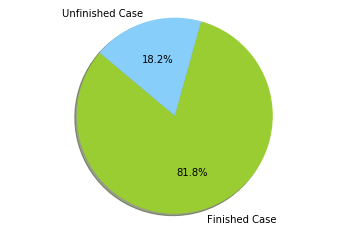

In [17]:
print("There are ",len(finishedcase),"of finished case and ",len(unfinishedcase),"unfinished case")
labels = 'Finished Case', 'Unfinished Case'
sizes = [len(finishedcase), len(unfinishedcase)]
colors = ['yellowgreen','lightskyblue']
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

There are  2563 of Long Checked case (>=60 days) and  25472 Normal Check Case
Long check average time is : 96
Normal Check AVG time is : 29


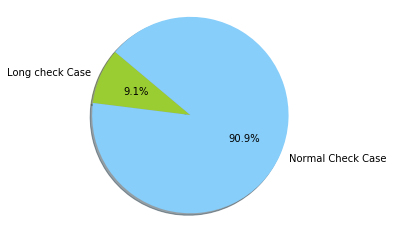

In [18]:
print("There are ",len(longcheck),"of Long Checked case (>=60 days) and ",len(normalcheck),"Normal Check Case")
print("Long check average time is :",computeAVG(longcheck))
print("Normal Check AVG time is :", computeAVG(normalcheck))
labels = 'Long check Case', 'Normal Check Case'
sizes = [len(longcheck), len(normalcheck)]
colors = ['yellowgreen','lightskyblue']
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

There are  27784 of Cleared case and  251 Rejected case


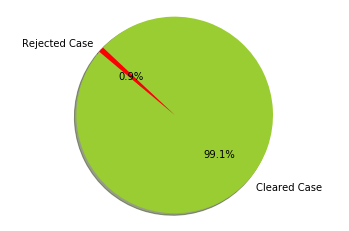

In [19]:
print("There are ",len(clearedcases),"of Cleared case and ",len(rejectedcases),"Rejected case")
labels = 'Cleared Case', 'Rejected Case'
sizes = [len(clearedcases), len(rejectedcases)]
colors = ['yellowgreen','red']
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

There are  23065 of New case and  11171 Renewal case


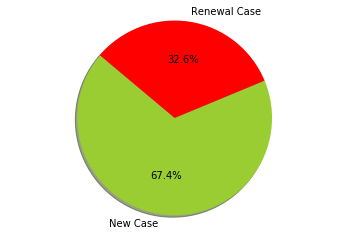

In [20]:
print("There are ",len(newcase),"of New case and ",len(renewalcase),"Renewal case")
labels = 'New Case', 'Renewal Case'
sizes = [len(newcase), len(renewalcase)]
colors = ['yellowgreen','red']
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

### Application per VISA Type
Saved to file : checkee.xlsx

In [21]:
#excel engine used is xlsxwriter, but somehow it keeps overwriting other sheets
#So becarefu when used, better to use a tmp.xlsx file when you do the operation
file = 'checkee.xlsx'
xl = pd.ExcelFile(file)
labels = list(APPperVisaType.keys())
sizes = []
for items in APPperVisaType:
    sizes.append(len(APPperVisaType[items]))
df1 = pd.DataFrame({'visatype': labels,'Sizes': sizes})
writer = pd.ExcelWriter(file, engine='xlsxwriter')
df1.to_excel(writer, 'Visatypes')

writer.save()

### Application per Consular
Saved to file : checkee.xlsx

In [22]:
labels = list(APPperConsular.keys())
sizes = []
for items in APPperConsular:
    sizes.append(len(APPperConsular[items]))
df1 = pd.DataFrame({'Consular': labels,'Sizes': sizes})
writer = pd.ExcelWriter(file, engine='xlsxwriter')
df1.to_excel(writer, 'Consular')

writer.save()

Among all the cleared cases ( 27784 cases )
The average clear time is  34 days


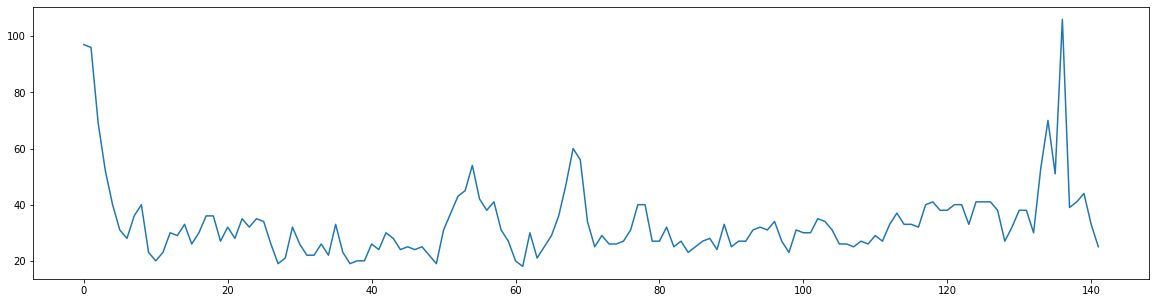

In [33]:
#Average Checking time among cleared case
waitingtime = []
for items in clearedcases:
    waitingtime.append(int(items[8]))

average = sum(waitingtime)//len(waitingtime)
print("Among all the cleared cases","(",len(waitingtime),"cases )")
print("The average clear time is ", average, "days")

#monthly average
MonthsList = list(CasebyMon.keys())
monthlyAVG = []
for keys in CasebyMon.keys():
    cur_mon = CasebyMon[keys]
    monthlyAVG.append(computeAVG(cur_mon))
plt.figure(figsize=(20,5))
#plt.hist(monthlyAVG, bins=30, facecolor="blue", edgecolor="black", alpha=0.7)
# print(monthlyAVG)
# monthliststr = []
# for items in MonthsList:
#     monthliststr.append(str(items))
plt.plot(monthlyAVG)
# print(monthliststr)

In [34]:
print(MonthsList)
print(monthlyAVG)


[200812, 200901, 200902, 200903, 200904, 200905, 200906, 200907, 200908, 200909, 200910, 200911, 200912, 201001, 201002, 201003, 201004, 201005, 201006, 201007, 201008, 201009, 201010, 201011, 201012, 201101, 201102, 201103, 201104, 201105, 201106, 201107, 201108, 201109, 201110, 201111, 201112, 201201, 201202, 201203, 201204, 201205, 201206, 201207, 201208, 201209, 201210, 201211, 201212, 201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308, 201309, 201310, 201311, 201312, 201401, 201402, 201403, 201404, 201405, 201406, 201407, 201408, 201409, 201410, 201411, 201412, 201501, 201502, 201503, 201504, 201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512, 201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904,

In [35]:
#monthly average
longcheckmonthlist = list(longcheckpermonth.keys())
longcheckmonthAVG = []
longcheckmonthMIN = []
longcheckmonthMAX = []
longcheckmonthcasenum = []

for keys in longcheckpermonth.keys():
    cur_mon = longcheckpermonth[keys]
    longcheckmonthAVG.append(computeAVG(cur_mon))
    longcheckmonthMIN.append(computeMIN(cur_mon))
    longcheckmonthMAX.append(computeMAX(cur_mon))
    longcheckmonthcasenum.append(len(cur_mon))
    
df1 = pd.DataFrame({'month': longcheckmonthlist,'avg time': longcheckmonthAVG,'MIN time': longcheckmonthMIN,'MAX time': longcheckmonthMAX,'monthly case num': longcheckmonthcasenum})
writer = pd.ExcelWriter(file, engine='xlsxwriter')
df1.to_excel(writer, 'long check avg time')

writer.save()

In [26]:
print(longcheckpermonth[201206])

[['oldboy', 'J1', 'New', 'BeiJing', 'CS', 'Clear', datetime.datetime(2012, 6, 1, 0, 0), datetime.datetime(2013, 5, 14, 0, 0), '347', None], ['Whatever', 'F1', 'Renewal', 'BeiJing', 'CS', 'Clear', datetime.datetime(2012, 6, 29, 0, 0), datetime.datetime(2013, 5, 28, 0, 0), '333', "ave waited for more than five months and still have no response. For God's sake! \r\nUpdate---it took me a year to get the clearance. Think twice before you go back!"]]


In [27]:
#APPperConsular
#longcheckperconsular
#rejectedperconsular
interestedconsular = ['BeiJing', 'ChengDu', 'ShangHai', 'GuangZhou', 'ShenYang', 'Europe']
consular_reject_num = []
consular_longcheck_num = []
consular_overall_case = []
for items in interestedconsular:
    consular_reject_num.append(len(rejectedperconsular[items]))
    consular_longcheck_num.append(len(longcheckperconsular[items]))
    consular_overall_case.append(len(APPperConsular[items]))
file = 'checkee.xlsx'
df1 = pd.DataFrame({'consular': interestedconsular,'overall case': consular_overall_case,'reject case': consular_reject_num,'long check case': consular_longcheck_num})
writer = pd.ExcelWriter(file, engine='xlsxwriter')
df1.to_excel(writer, 'consular summary')
writer.save()
    
print(interestedconsular)
print(consular_reject_num)
print(consular_longcheck_num)
print(consular_overall_case)

['BeiJing', 'ChengDu', 'ShangHai', 'GuangZhou', 'ShenYang', 'Europe']
[141, 16, 43, 28, 12, 2]
[1077, 168, 686, 181, 124, 69]
[12327, 1696, 8259, 2553, 1082, 460]


Text(0.5, 1.0, 'All Check Cases')

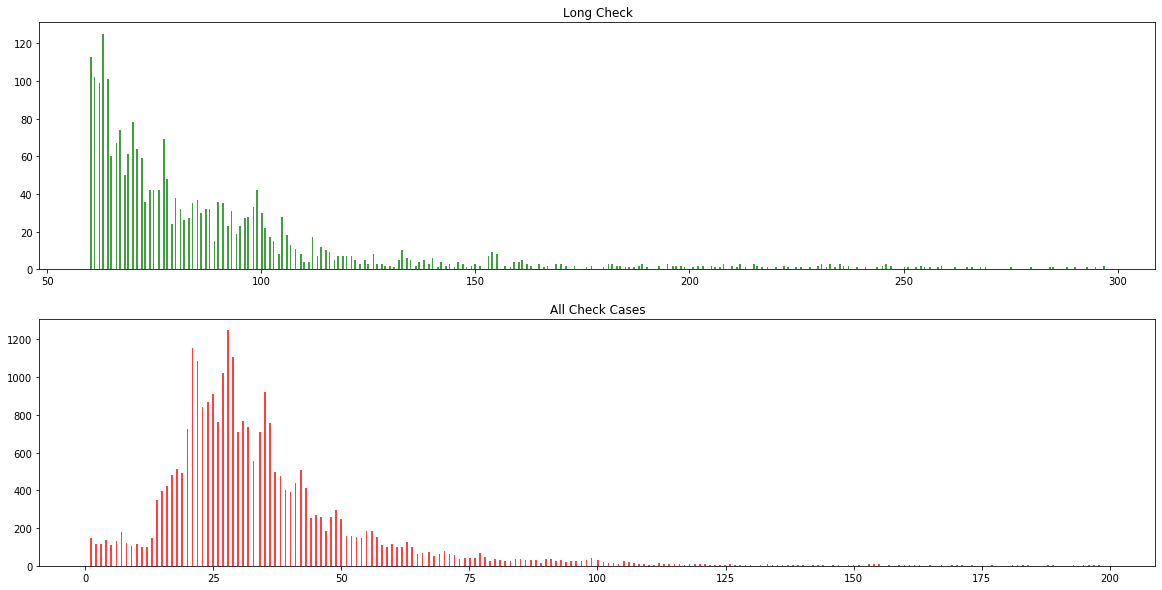

In [28]:
# plot histogram of the checking case and longcheck case
#finishedcase
#longcheck
checkdate = []
longcheckdate = []

for items in finishedcase:
    if(int(items[8])>0 and int(items[8])<200 ):
        checkdate.append(int(items[8]))
for items in longcheck:
    if(int(items[8])>0 and int(items[8])<300 ):
        longcheckdate.append(int(items[8]))
plt.figure(figsize=(20,10))
plt.subplot(211)
n, bins, patches = plt.hist(longcheckdate, 600, facecolor='g', alpha=0.75)
plt.title("Long Check")
plt.subplot(212)
n, bins, patches = plt.hist(checkdate, 600, facecolor='r', alpha=0.75)
plt.title("All Check Cases")

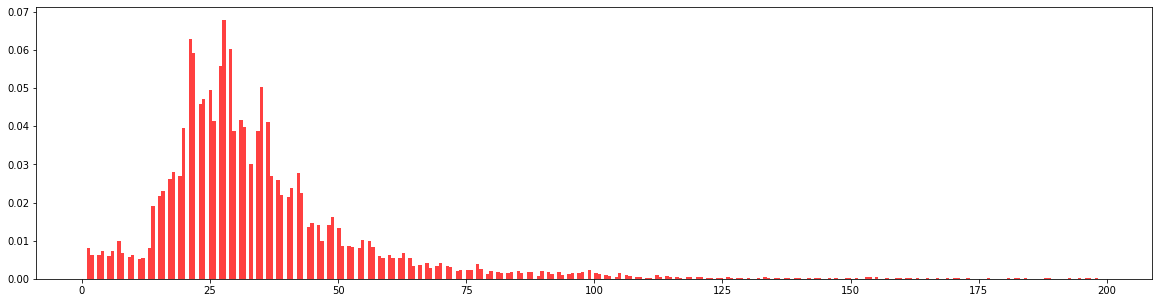

In [29]:
plt.figure(figsize=(20,5))
n, bins, patches = plt.hist(checkdate, 300, density=True, facecolor='r', alpha=0.75)

In [30]:
#print(rejectpervisatype["H1"])
print(rejectpervisatype.keys())
num_sum = []
for keys in rejectpervisatype:
    num_sum.append(len(rejectpervisatype[keys]))
print(num_sum)

dict_keys(['F1', 'J1', 'B2', 'B1', 'L2', 'H1', 'F2', 'L1', 'H4', 'J2', 'O1'])
[112, 55, 24, 31, 2, 15, 3, 3, 3, 2, 1]


In [31]:
f= codecs.open("dataprint_folder/H1rejected.txt","w+", "utf-8")
for items in rejectpervisatype["H1"]:
    printCase(f,items)
f.close()